In [153]:
import os
import pickle
from collections import Counter

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Dropout, Flatten, Dense
from keras.losses import SparseCategoricalCrossentropy
from keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

### Image Classification with Convolutional Neural Networks

#### Data Source
- Dataset used: [Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)


#### Initial Models
- In the course of this notebook, we have designed three initial models, each featuring distinct layer configurations, to evaluate their effectiveness in image classification tasks. 

#### Parameter Tuning and Image Augmentation
- Following the identification of the most promising configuration, we proceeded to fine-tune its parameters and applied image augmentation techniques. This was done to assess the impact of these adjustments on the model's predictive accuracy.


#### Performance Evaluation - Comparative Analysis
- Throughout our analysis, we meticulously compared several key performance metrics, including accuracy, precision, recall, F1-score, and support, in addition to examining the confusion matrix. This comprehensive evaluation allowed us to not only gauge the effectiveness of our models but also to refine our approach for enhanced image classification performance.


In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_labels = {
    x: i for i, x in enumerate(class_names)
}
nb_classes = len(class_names)
IMAGE_SIZE = (150, 150)


In [3]:
def load_data(path):
    images = []
    labels = []
    
    for folder in os.listdir(path):
        label = class_names_labels[folder]
        
        for file in os.listdir(os.path.join(path, folder)):
            img_path = os.path.join(os.path.join(path, folder), file)
            
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, IMAGE_SIZE)
            
            images.append(image)
            labels.append(label)
    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')
            
    return images, labels
    
    

In [4]:
training_data_path = "data/seg_train/seg_train"
testing_data_path = "data/seg_test/seg_test"

train_images, train_labels = load_data(training_data_path)
test_images, test_labels = load_data(testing_data_path)

### Exploratory data analysis of the dataset

#### Training dataset

In [5]:
# Available classes
class_names

['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']

Number all training images:

In [6]:
len(train_labels)

14034

Number of images with a particular class:

In [7]:
train_class_counter = {class_names[x]: y for x, y in Counter(train_labels).items()}
train_class_counter

{'forest': 2271,
 'buildings': 2191,
 'glacier': 2404,
 'street': 2382,
 'mountain': 2512,
 'sea': 2274}

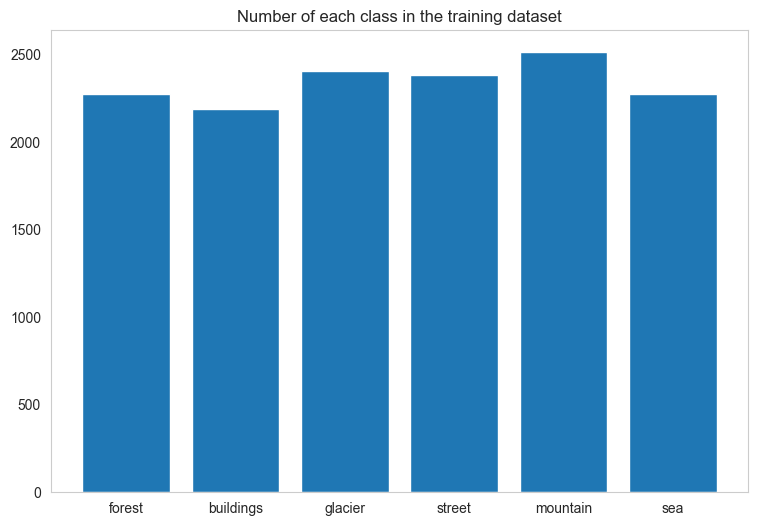

In [8]:
plt.figure(figsize=(9,6))
plt.bar(train_class_counter.keys(), train_class_counter.values())
plt.title("Number of each class in the training dataset")
plt.grid()

Our dataset is well-balanced, which means there's no need to employ any balancing techniques.

#### Testing dataset


Number all testing images:

In [9]:
len(test_labels)

3000

Number of images with a particular class:

In [10]:
test_class_counter = {class_names[x]: y for x, y in Counter(test_labels).items()}
test_class_counter

{'forest': 474,
 'buildings': 437,
 'glacier': 553,
 'street': 501,
 'mountain': 525,
 'sea': 510}

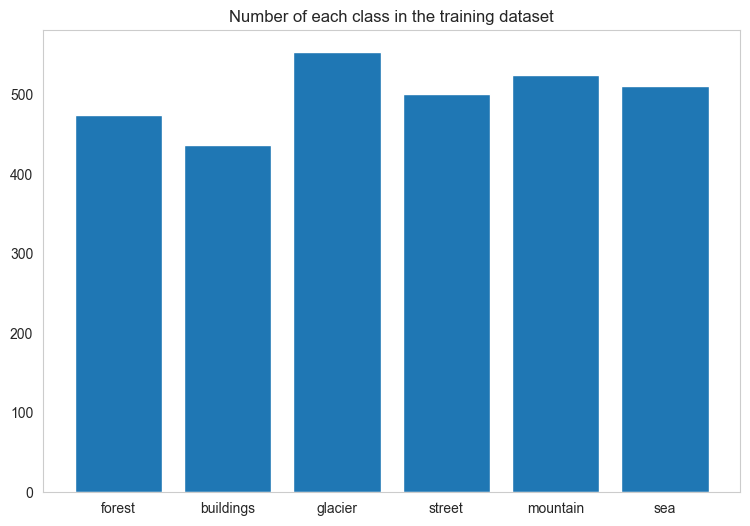

In [11]:
plt.figure(figsize=(9,6))
plt.bar(test_class_counter.keys(), test_class_counter.values())
plt.title("Number of each class in the training dataset")
plt.grid()

Similarly, for the test data, we can consider the dataset to be balanced.

In [12]:
# Scaling the data
train_images /= 255
test_images /= 255

# Shuffle data 
train_images, train_labels = shuffle(train_images, train_labels, random_state=1)

In [13]:
train_labels

array([0, 2, 2, ..., 4, 5, 4], dtype=int32)

In [14]:
def display_image(image, label):
    """
    Displays an RGB image using matplotlib in a Jupyter Notebook.

    Parameters:
    image (numpy.ndarray): The image to display, in RGB format.
    """
    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers
    plt.title(f"Class: {label}")
    plt.show()


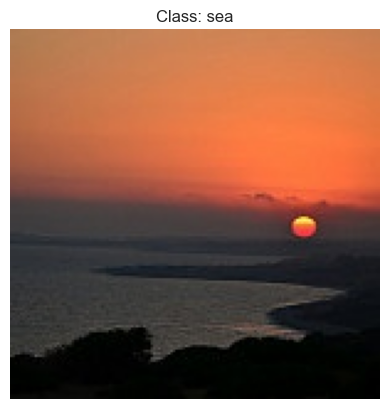

In [157]:
rnd_ind = np.random.randint(0, len(train_images))
label = class_names[train_labels[rnd_ind]]

display_image(train_images[rnd_ind], label)

#### Model

Let's define out first CNN model:

In [18]:
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPool2D((2, 2)),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])



In [20]:
model1.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       36992     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 128)      

In [23]:
history1 = model1.fit(train_images, train_labels, batch_size=128, epochs=30, validation_split=0.2)

Epoch 1/30


/Users/kacper/environments/machine-learning/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


88/88 [==============================] - 517s 6s/step - loss: 1.1742 - accuracy: 0.5533 - val_loss: 0.9050 - val_accuracy: 0.6544
Epoch 2/30
88/88 [==============================] - 406s 5s/step - loss: 0.7762 - accuracy: 0.7156 - val_loss: 0.7221 - val_accuracy: 0.7317
Epoch 3/30
88/88 [==============================] - 390s 4s/step - loss: 0.6498 - accuracy: 0.7657 - val_loss: 0.6825 - val_accuracy: 0.7567
Epoch 4/30
88/88 [==============================] - 404s 5s/step - loss: 0.5311 - accuracy: 0.8084 - val_loss: 0.6297 - val_accuracy: 0.7716
Epoch 5/30
88/88 [==============================] - 390s 4s/step - loss: 0.4401 - accuracy: 0.8401 - val_loss: 0.5887 - val_accuracy: 0.7870
Epoch 6/30
88/88 [==============================] - 404s 5s/step - loss: 0.3631 - accuracy: 0.8699 - val_loss: 0.5669 - val_accuracy: 0.7962
Epoch 7/30
88/88 [==============================] - 374s 4s/step - loss: 0.2651 - accuracy: 0.9114 - val_loss: 0.5543 - val_accuracy: 0.8108
Epoch 8/30
88/88 [======

In [24]:
# Serialize model as keras file
model1.save('model1.keras')

In [26]:
with open("history_model1.pkl", "wb") as file:
    pickle.dump(history1, file)


In [32]:
def draw_curves(history, key1='accuracy', ylim1=(0.7, 1.00), 
                key2='loss', ylim2=(0.0, 0.6)):
    plt.figure(figsize=(12,4))
    plt.plot(history.history1[key1], "r--")
    plt.plot(history.history1['val_' + key1], "g--")
    plt.ylabel(key1)
    plt.xlabel('Epoch')
    plt.ylim(ylim1)
    plt.legend(['train', 'test'], loc='best')
 
    plt.show()

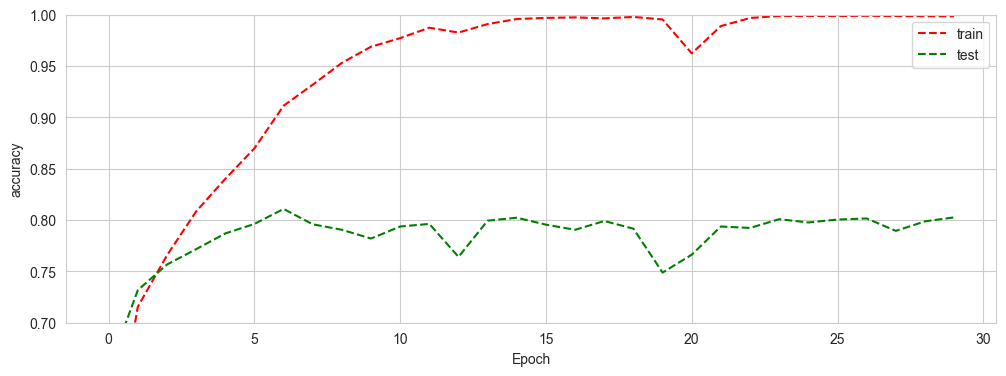

In [33]:
draw_curves(history1)

#### Validation on the test dataset

In [112]:
def show_confusion_matrix(y_test, y_pred, model_name="", target_ax=None, font_size=12):
    cm = confusion_matrix(y_test, y_pred)
    if target_ax is None:
        ax = plt.axes()
    else:
        ax = target_ax
    sns.heatmap(cm, annot=True, 
               annot_kws={"size": font_size}, 
               xticklabels=class_names, 
               yticklabels=class_names, ax = ax)
    ax.set_title(f'Confusion matrix - {model_name}')

In [118]:
test_loss1, accuracy1 = model1.evaluate(test_images, test_labels)
predictions1 = model1.predict(test_images)
pred_labels1 = np.argmax(predictions1, axis = 1)

94/94 [==============================] - 34s 355ms/step


In [78]:
test_loss1

1.199704885482788

In [77]:
print(classification_report(test_labels, pred_labels1, target_names=class_names_labels))

              precision    recall  f1-score   support

    mountain       0.76      0.76      0.76       525
      street       0.86      0.76      0.81       501
     glacier       0.71      0.83      0.76       553
   buildings       0.73      0.81      0.77       437
         sea       0.84      0.74      0.79       510
      forest       0.95      0.94      0.95       474

    accuracy                           0.80      3000
   macro avg       0.81      0.80      0.81      3000
weighted avg       0.81      0.80      0.80      3000


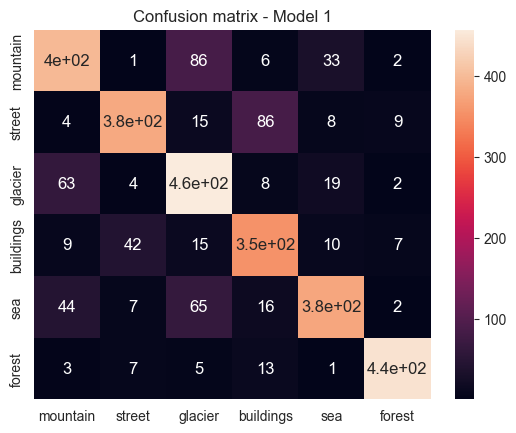

In [ ]:
show_confusion_matrix(test_labels, pred_labels1, "Model 1")


In the first model, we achieved an accuracy of 80% on the test dataset. Before proceeding with parameter tuning, we will first experiment with different layer configurations in the network. Let's start with a simpler model that includes one Conv2D layer, one MaxPool2D, and a Dropout layer.

#### Model 2

In [40]:
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPool2D((2, 2)),
    Dropout(0.25),

    
    Flatten(),
    Dense(256, activation='relu'),
    Dense(6, activation='softmax')
])



In [41]:
model2.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 74, 74, 32)        0         
                                                                 
 flatten_5 (Flatten)         (None, 175232)            0         
                                                                 
 dense_10 (Dense)            (None, 256)               44859648  
                                                                 
 dense_11 (Dense)            (None, 6)                 1542      
                                                      

In [42]:
history2 = model2.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split=0.2)

Epoch 1/20
88/88 [==============================] - 516s 6s/step - loss: 4.3054 - accuracy: 0.4506 - val_loss: 1.0688 - val_accuracy: 0.5957
Epoch 2/20
88/88 [==============================] - 364s 4s/step - loss: 0.9256 - accuracy: 0.6543 - val_loss: 0.8916 - val_accuracy: 0.6790
Epoch 3/20
88/88 [==============================] - 385s 4s/step - loss: 0.7150 - accuracy: 0.7454 - val_loss: 0.9627 - val_accuracy: 0.6619
Epoch 4/20
88/88 [==============================] - 337s 4s/step - loss: 0.5324 - accuracy: 0.8242 - val_loss: 0.7735 - val_accuracy: 0.7339
Epoch 5/20
88/88 [==============================] - 330s 4s/step - loss: 0.3899 - accuracy: 0.8770 - val_loss: 0.7416 - val_accuracy: 0.7421
Epoch 6/20
88/88 [==============================] - 391s 4s/step - loss: 0.2926 - accuracy: 0.9119 - val_loss: 0.7726 - val_accuracy: 0.7538
Epoch 7/20
88/88 [==============================] - 371s 4s/step - loss: 0.2247 - accuracy: 0.9348 - val_loss: 0.8009 - val_accuracy: 0.7449
Epoch 8/20
88

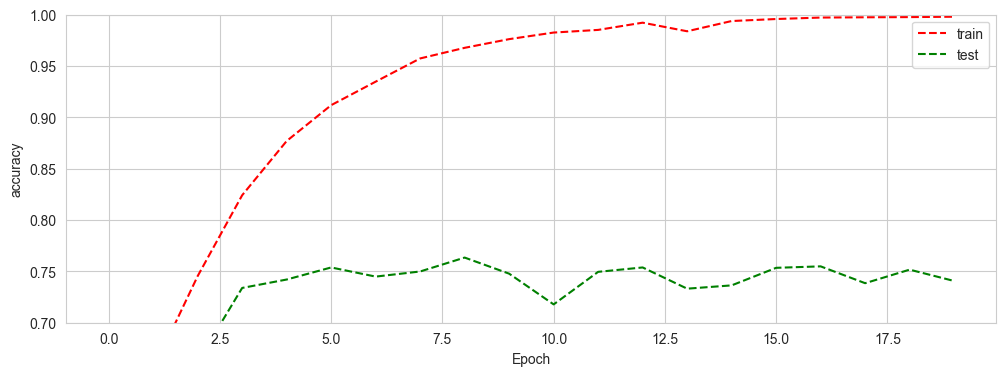

In [50]:
draw_curves(history2)

In [43]:
# Zapisz model jako zestaw plików TensorFlow
model2.save('model2.keras')

In [44]:
with open("history_model2.pkl", "wb") as file:
    pickle.dump(history2, file)


In [79]:
test_loss2, accuracy2 = model2.evaluate(test_images, test_labels)
predictions2 = model2.predict(test_images)
pred_labels2 = np.argmax(predictions2, axis = 1)

94/94 [==============================] - 21s 207ms/step


In [80]:
test_loss2

1.0872136354446411

In [81]:
print(classification_report(test_labels, pred_labels2, target_names=class_names_labels))

              precision    recall  f1-score   support

    mountain       0.72      0.65      0.68       525
      street       0.77      0.76      0.76       501
     glacier       0.70      0.76      0.73       553
   buildings       0.72      0.68      0.70       437
         sea       0.72      0.73      0.72       510
      forest       0.89      0.93      0.91       474

    accuracy                           0.75      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.75      0.75      0.75      3000


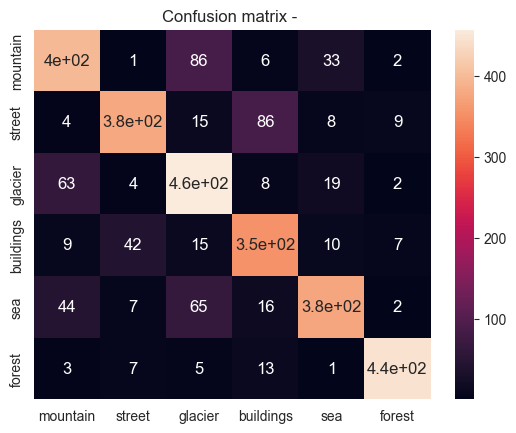

In [71]:
show_confusion_matrix(test_labels, pred_labels2)

In this configuration, the quality of predictions decreased - the accuracy is now 75%. Similar to Model 1, images of forests are classified most accurately. However, the model also struggles significantly with images classified as "glacier" or "mountain".

#### Model 3

In [45]:
model3 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])

In [46]:
model3.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 conv2d_17 (Conv2D)          (None, 146, 146, 64)      36928     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 73, 73, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 73, 73, 64)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 71, 71, 128)       73856     
                                                                 
 conv2d_19 (Conv2D)          (None, 69, 69, 128)       147584    
                                                      

In [47]:
history3 = model3.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split=0.2)


Epoch 1/20
88/88 [==============================] - 2285s 26s/step - loss: 1.3329 - accuracy: 0.5021 - val_loss: 0.9971 - val_accuracy: 0.6028
Epoch 2/20
88/88 [==============================] - 2097s 24s/step - loss: 0.8930 - accuracy: 0.6516 - val_loss: 0.8328 - val_accuracy: 0.6698
Epoch 3/20
88/88 [==============================] - 2085s 24s/step - loss: 0.7406 - accuracy: 0.7234 - val_loss: 0.8484 - val_accuracy: 0.6730
Epoch 4/20
88/88 [==============================] - 2080s 24s/step - loss: 0.6367 - accuracy: 0.7649 - val_loss: 0.6269 - val_accuracy: 0.7781
Epoch 5/20
88/88 [==============================] - 2104s 24s/step - loss: 0.5240 - accuracy: 0.8076 - val_loss: 0.6109 - val_accuracy: 0.7770
Epoch 6/20
88/88 [==============================] - 2093s 24s/step - loss: 0.4524 - accuracy: 0.8330 - val_loss: 0.6221 - val_accuracy: 0.7884
Epoch 7/20
88/88 [==============================] - 2129s 24s/step - loss: 0.3791 - accuracy: 0.8635 - val_loss: 0.6207 - val_accuracy: 0.7798

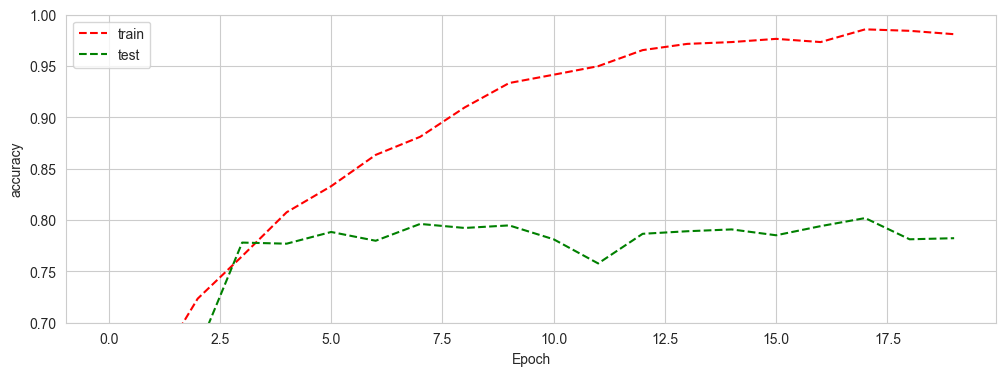

In [51]:
draw_curves(history3)

In [48]:
with open("history_model3.pkl", "wb") as file:
    pickle.dump(history3, file)


In [49]:
# Zapisz model jako zestaw plików TensorFlow
model3.save('model3.keras')

#### Validation on the test dataset

In [82]:
test_loss3, accuracy3 = model3.evaluate(test_images, test_labels)
predictions3 = model3.predict(test_images)
pred_labels3 = np.argmax(predictions3, axis = 1)

94/94 [==============================] - 201s 2s/step


In [83]:
test_loss3

1.252286434173584

In [84]:
print(classification_report(test_labels, pred_labels3, target_names=class_names_labels))

              precision    recall  f1-score   support

    mountain       0.68      0.77      0.72       525
      street       0.80      0.83      0.82       501
     glacier       0.69      0.79      0.74       553
   buildings       0.83      0.67      0.74       437
         sea       0.81      0.67      0.73       510
      forest       0.92      0.93      0.93       474

    accuracy                           0.78      3000
   macro avg       0.79      0.78      0.78      3000
weighted avg       0.78      0.78      0.78      3000


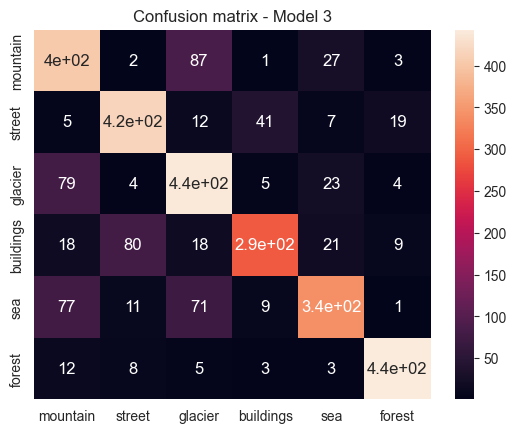

In [154]:
show_confusion_matrix(test_labels, pred_labels3, "Model 3")


In Model 3, the accuracy also hovers around 80%. By comparing precision, recall, and the F1 score, we can determine that the predictions are relatively similar - there are no significant differences observable.

### Comparision of the models

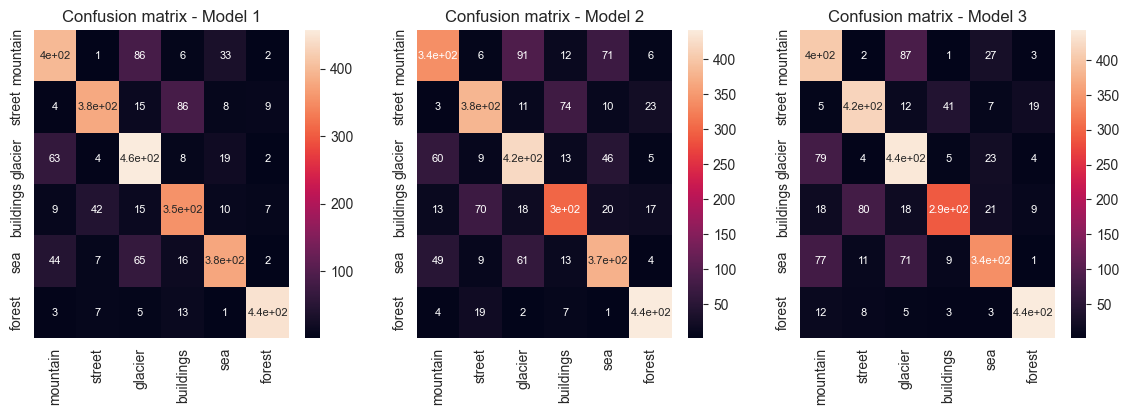

In [116]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
show_confusion_matrix(test_labels, pred_labels1, model_name="Model 1", target_ax=axs[0], font_size=8)
show_confusion_matrix(test_labels, pred_labels2, model_name="Model 2", target_ax=axs[1], font_size=8)
show_confusion_matrix(test_labels, pred_labels3, model_name="Model 3", target_ax=axs[2], font_size=8)

In [119]:
print(accuracy1, accuracy2, accuracy3)

0.8026666641235352 0.7509999871253967 0.778333306312561


In [122]:
print(test_loss1, test_loss2, test_loss3)

1.199704885482788 1.0872136354446411 1.252286434173584


#### Tuning of model 1

Let's now adjust some layer parameters in Model 1.

In [163]:
model1_tun = Sequential([
    Conv2D(64, (4, 4), activation='relu', input_shape=(150, 150, 3)),
    MaxPool2D((2, 2)),
    
    Conv2D(64, (4, 4), activation='relu'),
    MaxPool2D((2, 2)),
    
    Conv2D(128, (4, 4), activation='relu'),
    MaxPool2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])



In [164]:
model1_tun.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model1_tun.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 147, 147, 64)      3136      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 73, 73, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 70, 70, 64)        65600     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 35, 35, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 128)       131200    
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 16, 16, 128)     

In [166]:
history1_tun = model1_tun.fit(train_images, train_labels, batch_size=64, epochs=20, validation_split=0.2)

Epoch 1/20
176/176 [==============================] - 1019s 6s/step - loss: 0.6799 - accuracy: 0.7505 - val_loss: 0.7474 - val_accuracy: 0.7321
Epoch 2/20
176/176 [==============================] - 982s 6s/step - loss: 0.5734 - accuracy: 0.7907 - val_loss: 0.6828 - val_accuracy: 0.7399
Epoch 3/20
176/176 [==============================] - 777s 4s/step - loss: 0.4606 - accuracy: 0.8317 - val_loss: 0.5792 - val_accuracy: 0.7994
Epoch 4/20
176/176 [==============================] - 758s 4s/step - loss: 0.3664 - accuracy: 0.8714 - val_loss: 0.5825 - val_accuracy: 0.7923
Epoch 5/20
176/176 [==============================] - 710s 4s/step - loss: 0.2852 - accuracy: 0.8958 - val_loss: 0.5877 - val_accuracy: 0.8051
Epoch 6/20
176/176 [==============================] - 838s 5s/step - loss: 0.1992 - accuracy: 0.9282 - val_loss: 0.6562 - val_accuracy: 0.8151
Epoch 7/20
176/176 [==============================] - 1004s 6s/step - loss: 0.1510 - accuracy: 0.9499 - val_loss: 0.8346 - val_accuracy: 0.77

In [24]:
model1_tun.save('model1.keras')

In [26]:
with open("history_model1_tun.pkl", "wb") as file:
    pickle.dump(history1_tun, file)
 

In [ ]:
draw_curves(history1_tun)


In [ ]:
test_loss1_tun, accuracy1_tun = model1_tun.evaluate(test_images, test_labels)
predictions1_tun = model1_tun.predict(test_images)
pred_labels1_tun = np.argmax(predictions1_tun, axis = 1)

In [77]:
print(classification_report(test_labels, pred_labels1_tun, target_names=class_names_labels))

              precision    recall  f1-score   support

    mountain       0.76      0.76      0.76       525
      street       0.86      0.76      0.81       501
     glacier       0.71      0.83      0.76       553
   buildings       0.73      0.81      0.77       437
         sea       0.84      0.74      0.79       510
      forest       0.95      0.94      0.95       474

    accuracy                           0.80      3000
   macro avg       0.81      0.80      0.81      3000
weighted avg       0.81      0.80      0.80      3000


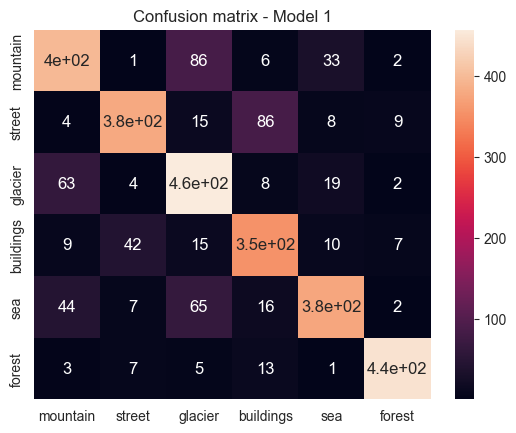

In [155]:
show_confusion_matrix(test_labels, pred_labels1_tun, "Model 1 tuned")


Changing the parameters did not affect the performance - accuracy remains at 80%. Furthermore, the prediction on the test set is identical - all the values for precision, recall, F1-score, and support are the same for both the original Model 1 and the one with tuned parameters.

#### Augmenting the images

Define image augmentation in the ImageDataGenerator to increase the dataset's diversity.

In [130]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(
    train_images,
    train_labels
)


In [131]:
model1_aug = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPool2D((2, 2)),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6, activation='softmax')
])

model1_aug.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])



In [139]:
history1_aug = model1_aug.fit(train_generator, batch_size=128, epochs=20)


Epoch 1/20
439/439 [==============================] - 774s 2s/step - loss: 0.7891 - accuracy: 0.7025
Epoch 2/20
439/439 [==============================] - 575s 1s/step - loss: 0.7242 - accuracy: 0.7322
Epoch 3/20
439/439 [==============================] - 586s 1s/step - loss: 0.7009 - accuracy: 0.7426
Epoch 4/20
439/439 [==============================] - 589s 1s/step - loss: 0.6615 - accuracy: 0.7549
Epoch 5/20
439/439 [==============================] - 630s 1s/step - loss: 0.6339 - accuracy: 0.7645
Epoch 6/20
439/439 [==============================] - 622s 1s/step - loss: 0.6155 - accuracy: 0.7733
Epoch 7/20
439/439 [==============================] - 574s 1s/step - loss: 0.6008 - accuracy: 0.7822
Epoch 8/20
439/439 [==============================] - 688s 2s/step - loss: 0.5820 - accuracy: 0.7875
Epoch 9/20
439/439 [==============================] - 661s 2s/step - loss: 0.5709 - accuracy: 0.7923
Epoch 10/20
439/439 [==============================] - 630s 1s/step - loss: 0.5572 - accura

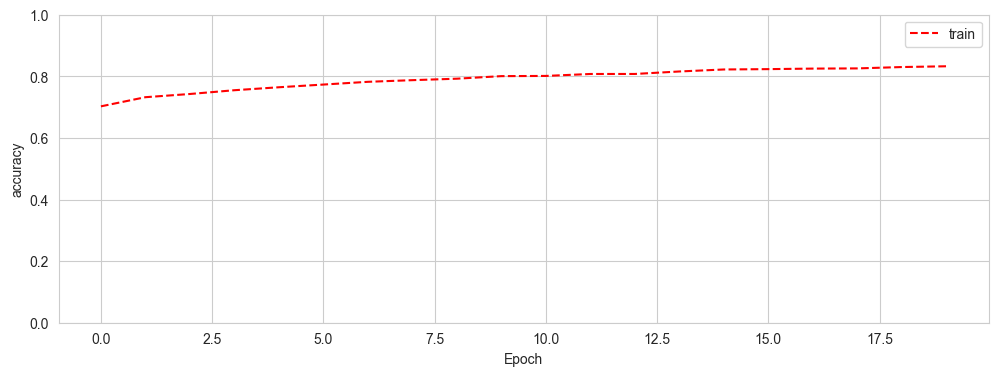

In [143]:
plt.figure(figsize=(12,4))
plt.plot(history1_aug.history['accuracy'], "r--")
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.legend(['train', 'test'], loc='best')

In [144]:
test_loss1_aug, accuracy1_aug = model1_aug.evaluate(test_images, test_labels)
predictions1_aug = model1_aug.predict(test_images)
pred_labels1_aug = np.argmax(predictions1_aug, axis = 1)

94/94 [==============================] - 26s 277ms/step


In [145]:
test_loss1_aug

0.523012101650238

In [147]:
print(classification_report(test_labels, pred_labels1_aug, target_names=class_names_labels))

              precision    recall  f1-score   support

    mountain       0.87      0.65      0.74       525
      street       0.80      0.85      0.83       501
     glacier       0.83      0.76      0.79       553
   buildings       0.71      0.87      0.78       437
         sea       0.82      0.86      0.84       510
      forest       0.94      0.98      0.96       474

    accuracy                           0.82      3000
   macro avg       0.83      0.83      0.82      3000
weighted avg       0.83      0.82      0.82      3000


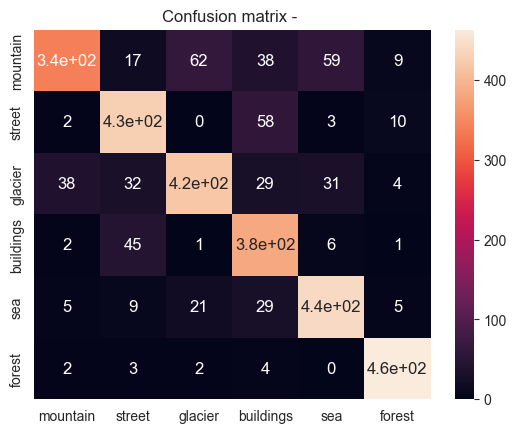

In [148]:
show_confusion_matrix(test_labels, pred_labels1_aug)

#### Comparison with the identical model but not augmented 

In [149]:
print(f"Accuracy:\nNot augumented model: {accuracy1}\nAugmented model: {accuracy1_aug}")

Accuracy:
Not augumented model: 0.8026666641235352
Augmented model: 0.8243333101272583


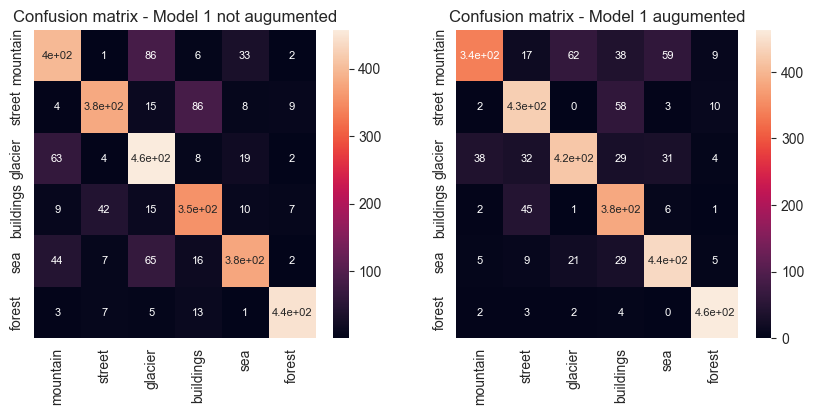

In [152]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
show_confusion_matrix(test_labels, pred_labels1, model_name="Model 1 not augumented", target_ax=axs[0], font_size=8)
show_confusion_matrix(test_labels, pred_labels1_aug, model_name="Model 1 augumented", target_ax=axs[1], font_size=8)

As can be seen, augmenting images during training yielded good results - we slightly increased the accuracy to 82%. After augmentation, there were significantly more correct predictions for images of "street", "buildings", "sea", and "forest"; however, the remaining classes were classified less accurately.




